# Preprocessing and packing

In [1]:
%matplotlib agg
import io
import os
import re
import time
import json
import hashlib
import tarfile
import requests
import tempfile
import warnings
import functools
import contextlib
import subprocess
from pathlib import Path

import bs4
import docker
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation
import natsort as ns
import tqdm.notebook as tqdm

import Bio.PDB
import Bio.SeqIO
import Bio.Align.AlignInfo
import Bio.AlignIO
import Bio.Alphabet

import torch
import torch_sparse
import torch_scatter
import torch_geometric as tg
from torch_geometric.data import Data, Batch
from torch_geometric.nn import radius_graph
from torch_geometric.transforms import Compose, Distance, PointPairFeatures

from loguru import logger
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Markdown, HTML, Video

from graphqa.data.aminoacids import *
from graphqa.data.decoys import ca_coord_and_orientation

pd.set_option("display.max_columns", 25)

def add_levels(df, *levels, axis=0):
    level, *levels = levels
    if len(levels) > 0:
        df = add_levels(df, *levels, axis=axis)
    return pd.concat((df,), keys=(level,), axis=axis)

## Primary structure

Encode amino-acid sequence as `uint8` arrays.

In [2]:
class FastaWrapper(object):
    def __init__(self, path):
        self.seq_iterator = Bio.SeqIO.parse(path, format="fasta")
        self.cache = {}

    @staticmethod
    def encode_seq(seq):
        return np.array([aa_1_mapping[aa] for aa in seq], dtype=np.uint8)

    def __getitem__(self, item):
        if not item in self.cache:
            for seq in self.seq_iterator:
                self.cache[seq.name] = FastaWrapper.encode_seq(seq)
                if seq.name == item:
                    break
        return self.cache.pop(item)

    def __str__(self):
        return f"{self.__class__.__name__}({len(self.cache)} cached sequences)"


df_sequences = pd.read_csv("sequences.csv")
target_lengths = df_sequences.set_index("target_id")["length"].to_dict()

casp_ed = 11
target_id = "T0759"
fw = FastaWrapper("CASP11/sequences.fasta")

sequence = fw[target_id]
seq_length = target_lengths[target_id]
assert seq_length == len(sequence)

print(seq_length, "".join(aa_1_mapping_inv[aa] for aa in sequence))

109 MGHHHHHHSHMVVIHPDPGRELSPEEAHRAGLIDWNMFVKLRSQECDWEEISVKGPNGESSVIHDRKSGKKFSIEEALQSGRLTPAHYDRYVNKDMSIQELAVLVSGQK


Compute multiple-sequence alignment features:

In [3]:
all_msa_counts = pd.read_pickle(f"CASP{casp_ed}/alignments.pkl")
msa_counts = all_msa_counts[target_id]
msa_freq = msa_counts / msa_counts.values.sum(axis=1, keepdims=True)
msa_freq.round(2)

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V,X
M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
G,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
H,0.00,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.06,0.09,0.00,0.00,0.00,0.00,0.03,0.0,0.06,0.00,0.0
H,0.00,0.03,0.22,0.00,0.00,0.03,0.36,0.01,0.06,0.00,0.00,0.01,0.00,0.00,0.00,0.26,0.01,0.0,0.00,0.00,0.0
H,0.03,0.00,0.08,0.01,0.00,0.01,0.04,0.00,0.06,0.02,0.04,0.03,0.02,0.00,0.01,0.36,0.31,0.0,0.00,0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.37,0.24,0.00,0.00,0.02,0.00,0.00,0.00,0.0,0.01,0.32,0.0
S,0.09,0.01,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.16,0.06,0.01,0.01,0.04,0.00,0.36,0.19,0.0,0.02,0.02,0.0
G,0.02,0.00,0.04,0.01,0.00,0.00,0.04,0.50,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.27,0.01,0.0,0.00,0.00,0.0
Q,0.00,0.10,0.22,0.05,0.00,0.20,0.20,0.01,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.04,0.00,0.0,0.00,0.00,0.0


## Tertiary structure and DSSP (inputs)
Assume there is only one model per file and only one chain per model.

In [4]:
# (None, 0) means missing residue or missing DSSP features
ss_dssp_mapping = {
    None: 0,
    "G": 1,
    "H": 2,
    "I": 3,
    "T": 4,
    "E": 5,
    "B": 6,
    "S": 7,
    "-": 8,
}


def load_decoy_feats(df_decoys, seq_length):
    decoy_feats = {}
    parser = Bio.PDB.PDBParser(QUIET=True)

    for decoy in df_decoys.itertuples():
        try:
            # Load structure and DSSP
            structure = parser.get_structure(
                f"{decoy.target_id}/{decoy.decoy_id}",
                f"CASP{decoy.casp_ed}/decoys/{decoy.target_id}/{decoy.decoy_id}.pdb",
            )
            dssp = Bio.PDB.DSSP(
                structure[0],
                f"CASP{decoy.casp_ed}/decoys/{decoy.target_id}/{decoy.decoy_id}.dssp",
                file_type="DSSP",
            )

            # Tertiary structure features
            coords_ca = np.full((seq_length, 3), dtype=np.float32, fill_value=np.nan)
            orient_res = np.full((seq_length, 3), dtype=np.float32, fill_value=np.nan)

            # DSSP features
            secondary_structure = np.full(
                (seq_length,), dtype=np.uint8, fill_value=ss_dssp_mapping[None]
            )
            phi = np.full((seq_length,), dtype=np.float32, fill_value=np.nan)
            psi = np.full((seq_length,), dtype=np.float32, fill_value=np.nan)
            surface_acc = np.full((seq_length,), dtype=np.float32, fill_value=np.nan)

            # Assume there is only one model per file and only one chain per model
            model = next(structure.get_models())
            chain = next(model.get_chains())
            for residue in chain:
                _, idx, _ = residue.id
                idx = idx - 1

                # Tertiary structure features
                ca, orient = ca_coord_and_orientation(residue)
                coords_ca[idx] = ca
                orient_res[idx] = orient

                # Some residues don't have DSSP features
                if len(residue.xtra) > 0:
                    secondary_structure[idx] = ss_dssp_mapping[residue.xtra["SS_DSSP"]]
                    phi[idx] = residue.xtra["PHI_DSSP"]
                    psi[idx] = residue.xtra["PSI_DSSP"]
                    surface_acc[idx] = residue.xtra["EXP_DSSP_RASA"]

            df_decoy = pd.DataFrame(
                {
                    ("coords_ca", "x"): coords_ca[:, 0],
                    ("coords_ca", "y"): coords_ca[:, 1],
                    ("coords_ca", "z"): coords_ca[:, 2],
                    ("orient_res", "x"): orient_res[:, 0],
                    ("orient_res", "y"): orient_res[:, 1],
                    ("orient_res", "z"): orient_res[:, 2],
                    ("dssp", "ss"): secondary_structure,
                    ("dssp", "surface_acc"): surface_acc,
                    ("dssp", "phi"): phi,
                    ("dssp", "psi"): psi,
                }
            )
            decoy_feats[decoy.decoy_id] = df_decoy
        except Exception as e:
            logger.warning(
                f"{decoy.target_id}/{decoy.decoy_id}: {e.__class__.__name__} {e}"
            )

    return pd.concat(
        decoy_feats.values(),
        axis=0,
        join="inner",
        keys=decoy_feats.keys(),
        names=["decoy_id", "residue_idx"],
    )

In [5]:
df_decoys = pd.read_csv("decoys.csv").query(f'target_id == "{target_id}"')
df_decoy_feats = load_decoy_feats(df_decoys, seq_length=target_lengths[target_id])

print("Num decoys:", df_decoy_feats.index.levels[0].nunique())
df_decoy_feats

Num decoys: 179


coords_ca                       orient_res  \
                                       x          y          z          x   
decoy_id           residue_idx                                              
3D-Jigsaw-V5_1_TS1 0                 NaN        NaN        NaN        NaN   
                   1                 NaN        NaN        NaN        NaN   
                   2                 NaN        NaN        NaN        NaN   
                   3                 NaN        NaN        NaN        NaN   
                   4                 NaN        NaN        NaN        NaN   
...                                  ...        ...        ...        ...   
slbio_TS5          104            13.883 -15.369000  27.601999   0.213131   
                   105            13.187 -18.413000  25.545000   0.600814   
                   106             9.949 -19.941000  26.643999  -0.933933   
                   107            10.319 -23.627001  27.055000   0.922355   
                   108             8.167 -26.638000  27.700001  -0.598281   

                                                   dssp              \
                                       y         z   ss surface_acc   
decoy_id           residue_idx                                        
3D-Jigsaw-V5_1_TS1 0                 NaN       NaN    0         NaN   
                   1                 NaN       NaN    0         NaN   
                   2                 NaN       NaN    0         NaN   
                   3                 NaN       NaN    0         NaN   
                   4                 NaN       NaN    0         NaN   
...                                  ...       ...  ...         ...   
slbio_TS5          104         -0.454063  0.865103    8    0.014085   
                   105         -0.714604 -0.358278    8    0.161538   
                   106          0.126300 -0.334391    8    0.273810   
                   107         -0.233671  0.307667    8    0.737374   
                   108         -0.405559 -0.691073    8    1.000000   

                                                        
                                       phi         psi  
decoy_id           residue_idx                          
3D-Jigsaw-V5_1_TS1 0                   NaN         NaN  
                   1                   NaN         NaN  
                   2                   NaN         NaN  
                   3                   NaN         NaN  
                   4                   NaN         NaN  
...                                    ...         ...  
slbio_TS5          104           66.000000  167.300003  
                   105          -68.300003  133.399994  
                   106          -80.500000  148.399994  
                   107         -146.399994  152.699997  
                   108         -108.599998  360.000000  

[19511 rows x 10 columns]

## QA scores (outputs)

In [6]:
def load_scores(casp_ed, target_id):
    lddt_dict = np.load(f"CASP{casp_ed}/decoys/{target_id}.lddt.npz")
    global_lddt = pd.Series(
        lddt_dict["global_lddt"], index=lddt_dict["decoys"], name="lddt"
    )
    local_lddt = pd.DataFrame(lddt_dict["local_lddt"], index=lddt_dict["decoys"])

    tmscore_dict = np.load(f"CASP{casp_ed}/decoys/{target_id}.tmscore.npz")
    df_tmscore = pd.DataFrame({**tmscore_dict}).set_index("decoys")

    cad_dict = np.load(f"CASP{casp_ed}/decoys/{target_id}.cad.npz")
    global_cad = pd.Series(cad_dict["global_cad"], index=cad_dict["decoys"], name="cad")
    local_cad = pd.DataFrame(cad_dict["local_cad"], index=cad_dict["decoys"])

    df_global = pd.concat((df_tmscore, global_lddt, global_cad), axis=1).rename_axis(
        index="decoy_id"
    )

    df_local = (
        pd.concat(
            (local_lddt.stack(dropna=False), local_cad.stack(dropna=False)),
            axis=1,
            keys=["lddt", "cad"],
            join="inner",
        )
        .sort_index()
        .rename_axis(index=["decoy_id", "residue_idx"])
    )

    return df_global, df_local

In [7]:
df_global, df_local = load_scores(casp_ed, target_id)
display(df_global.round(2))
display(df_local.round(2))

,rmsd,tm_score,gdt_ts,gdt_ha,lddt,cad
decoy_id,,,,,,
HHPredX_TS1,13.88,0.37,0.39,0.32,0.47,0.40
nns_TS4,13.46,0.43,0.41,0.29,0.56,0.41
QUARK_TS4,14.08,0.35,0.35,0.28,0.50,0.42
MULTICOM-REFINE_TS1,13.72,0.37,0.37,0.29,0.48,0.41
BhageerathH_TS4,14.27,0.21,0.22,0.13,0.33,0.16
...,...,...,...,...,...,...
MULTICOM-NOVEL_TS1,12.99,0.36,0.38,0.29,0.46,0.36
Alpha-Gelly-Server_TS4,15.04,0.32,0.32,0.24,0.43,0.34
FALCON_MANUAL_TS3,13.28,0.37,0.37,0.30,0.47,0.34


lddt   cad
decoy_id           residue_idx            
3D-Jigsaw-V5_1_TS1 0             NaN   NaN
                   1             NaN   NaN
                   2             NaN   NaN
                   3             NaN   NaN
                   4             NaN   NaN
...                              ...   ...
slbio_TS5          104          0.34  0.20
                   105          0.30  0.08
                   106          0.29  0.24
                   107           NaN   NaN
                   108           NaN   NaN

[19511 rows x 2 columns]

## Packing

In [232]:
def compute_msa_features(msa_counts: pd.DataFrame) -> pd.DataFrame:
    msa_freq = msa_counts / msa_counts.values.sum(axis=1, keepdims=True)
    return msa_freq

def to_graph(
    casp_ed: int, 
    target_id: str, 
    decoy_id: str, 
    decoy_feats: pd.DataFrame,
    qa_global: pd.DataFrame, 
    qa_local: pd.DataFrame,
) -> Data:
    graph = Data(
        # Metadata
        # casp_ed=casp_ed,
        # target_id=target_id,
        decoy_id=decoy_id,
        num_nodes=len(sequence),
        # n_nodes=len(sequence),

        # Node features
        # msa_feats=torch.from_numpy(msa_feats.values).float()
        x=torch.from_numpy(decoy_feats['dssp'][["surface_acc", "phi", "psi"]].values).float(),

        # Categorical features
        # aa=torch.from_numpy(sequence),
        secondary_structure=torch.from_numpy(decoy_feats["dssp"]["ss"].values),

        # Spatial features
        pos=torch.from_numpy(
            decoy_feats['coords_ca'].values
        ).float(),
        norm=torch.from_numpy(
            decoy_feats['orient_res'].values
        ).float(),

        # QA targets
        qa_global=torch.from_numpy(
            qa_global[['tm_score','gdt_ts','gdt_ha','lddt','cad']].values
        ).float()[None, :],
        qa_local=torch.from_numpy(
            qa_local[['lddt','cad']].values
        ).float(),
    )
    return graph

In [92]:
class RadiusGraphWithNans(object):
    def __init__(self, r, loop=False, max_num_neighbors=32):
        self.r = r
        self.loop = loop
        self.max_num_neighbors = max_num_neighbors

    def __call__(self, data: Data)->Data:
        data.edge_attr = None
        nans = torch.isnan(data.pos[:, 0])
        pos = data.pos.clone()
        pos[nans] = 10_000
        batch = data.batch if "batch" in data else None

        edge_index = radius_graph(
            pos, self.r, batch, self.loop, self.max_num_neighbors,
        )
        drop = torch.any(edge_index[0] == torch.nonzero(nans), dim=0) | torch.any(
            edge_index[1] == torch.nonzero(nans), dim=0
        )

        data.edge_index = edge_index[:, ~drop]
        return data


class SequentialEdges(object):
    '''
    Add H-hop edges to a linear graph.
    For a linear graph with N nodes, each hop of distance h adds 2*(N-h) directed edges.
    Adding all edges from h=1 to h=H gives H*(2*N-H-1) edges.
    '''
    def __init__(self, hops=3):
        self.hops = tuple(range(1, hops + 1))

    def __call__(self, data: Data)->Data:
        if 'batch' in data:
            raise ValueError('Doesn\'t work with batched graphs')
        if 'edge_attr' in data:
            raise ValueError('Can\'t add new edges to a graph with edge attributes')
        
        forward_hop_edges = torch.tensor(
            [(i, i + hop) for hop in self.hops for i in range(data.num_nodes - hop)]
        ).transpose(0, 1)
        backward_hop_edges = forward_hop_edges[[1, 0], :]

        if data.edge_index is None:
            data.edge_index = torch.cat(
                (forward_hop_edges, backward_hop_edges), dim=1
            )
        else:
            data.edge_index = torch.cat(
                (data.edge_index, forward_hop_edges, backward_hop_edges), dim=1
            )
        
        return data.coalesce()
    
class FillNa(object):
    def __call__(self, data: Data)->Data:
        data.x = torch.where(torch.isnan(data.x), torch.tensor(0.), data.x)
        data.edge_attr = torch.where(torch.isnan(data.edge_attr), torch.tensor(0.), data.edge_attr)
        return data
    
class CleanUp(object):
    def __call__(self, data: Data)->Data:
        data.pos = None
        data.norm = None
        return data

In [101]:
df_decoys = pd.read_csv("decoys.csv")
target_lengths = pd.read_csv("sequences.csv").set_index("target_id")["length"].to_dict()

transforms = Compose(
    [
        RadiusGraphWithNans(r=12, loop=False, max_num_neighbors=128),
        SequentialEdges(hops=5),
        # Distance(norm=True, max_value=12),
        PointPairFeatures(),
        FillNa(),
        CleanUp(),
    ]
)    

df_processed = []
for casp_ed, df_decoys in df_decoys.groupby("casp_ed"):
    fasta_wrapper = FastaWrapper(f"CASP{casp_ed}/sequences.fasta")
    msa_counts_dict = pd.read_pickle(f"CASP{casp_ed}/alignments.pkl")

    Path(f"CASP{casp_ed}/processed").mkdir(exist_ok=True)

    for target_id, df_decoys in df_decoys.groupby("target_id"):
        if Path(f"CASP{casp_ed}/processed/{target_id}.pth").is_file():
            logger.debug(f'Already done CASP{casp_ed}/{target_id}')
            continue
        logger.info(f"Processing CASP{casp_ed}/{target_id}")

        try:
            df_qa_global, df_qa_local = load_scores(casp_ed, target_id)
        except Exception as e:
            logger.error(f"QA scores error: {e}")
            continue

        try:
            df_decoy_feats = load_decoy_feats(
                df_decoys, seq_length=target_lengths[target_id]
            )
        except Exception as e:
            logger.error(f"Decoy features error: {e}")
            continue

        try:
            sequence = fasta_wrapper[target_id]
        except Exception as e:
            logger.error(f"Primary sequence error: {e}")
            continue

        try:
            df_msa_counts = msa_counts_dict[target_id]
            df_msa_feats = compute_msa_features(df_msa_counts)
        except KeyError as e:
            logger.error(f"MSA is missing: {e}")
            continue
        except Exception as e:
            logger.error(f"MSA error: {e}")
            continue
            
        joint_index = pd.MultiIndex.join(
            df_qa_local.index.droplevel('residue_idx').drop_duplicates(), 
            df_decoy_feats.index.droplevel('residue_idx').drop_duplicates(),
            how='inner',
        ).join(
            df_qa_global.index,
            how='inner',
        )
        
        """
        display(sequence)
        display(df_msa_feats.round(2))
        display(pd.concat(
            (df_decoy_feats, add_levels(df_qa_local, 'qa_local', axis=1)),
            axis=1,
            join='inner'
        ).sort_index().round(2))
        display(df_qa_global.round(2))
        display(joint_index)
        """
        
        graphs = []
        for decoy_id in joint_index:        
            graph = to_graph(
                decoy_id=decoy_id,
                decoy_feats=df_decoy_feats.loc[decoy_id],
                qa_local=df_qa_local.loc[decoy_id],
                qa_global=df_qa_global.loc[decoy_id],
            )
            graph = transforms(graph)
            graph.debug()
            graphs.append(graph)
        
        torch.save({
            'casp_ed':casp_ed,
            'target_id':target_id,
            'sequence':torch.from_numpy(sequence),
            'msa_feats':torch.from_numpy(df_msa_feats.values).float(),
            'graphs':graphs,
        }, f"CASP{casp_ed}/processed/{target_id}.pth")

2020-04-08 18:23:50.224 | DEBUG    | __main__:<module>:24 - Already done CASP9/T0515
2020-04-08 18:23:50.226 | INFO     | __main__:<module>:26 - Processing CASP9/T0516
2020-04-08 18:23:52.122 | WARNING  | __main__:load_decoy_feats:79 - T0516/SAM-T02-server_AL3: KeyError 'CB'
2020-04-08 18:23:54.651 | WARNING  | __main__:load_decoy_feats:79 - T0516/FUGUE_KM_AL5: KeyError 'CB'
2020-04-08 18:23:56.852 | WARNING  | __main__:load_decoy_feats:79 - T0516/SAM-T02-server_AL5: KeyError 'CB'
2020-04-08 18:23:58.526 | WARNING  | __main__:load_decoy_feats:79 - T0516/FUGUE_KM_AL1: KeyError 'CB'
2020-04-08 18:24:00.071 | WARNING  | __main__:load_decoy_feats:79 - T0516/FUGUE_KM_AL3: KeyError 'CB'
2020-04-08 18:24:03.357 | WARNING  | __main__:load_decoy_feats:79 - T0516/SAM-T02-server_AL2: KeyError 'CB'
2020-04-08 18:24:03.932 | WARNING  | __main__:load_decoy_feats:79 - T0516/SAM-T02-server_AL1: KeyError 'CB'
2020-04-08 18:24:06.265 | WARNING  | __main__:load_decoy_feats:79 - T0516/FUGUE_KM_AL2: KeyErr

In [243]:
! ls CASP*/processed/*.pth | wc -l
! du -hsc CASP*/processed

390
4.8G	CASP10/processed
2.9G	CASP11/processed
1.6G	CASP12/processed
2.5G	CASP13/processed
5.1G	CASP9/processed
17G	total


Data(casp_ed=[1], decoy_id=3D-JIGSAW_SL1_TS1, edge_attr=[978, 4], edge_index=[2, 978], n_nodes=[1], qa_global=[1, 5], qa_local=[52, 2], secondary_structure=[52], target_id=T0980s2, x=[52, 3])
Data(casp_ed=[1], decoy_id=3D-JIGSAW_SL1_TS2, edge_attr=[976, 4], edge_index=[2, 976], n_nodes=[1], qa_global=[1, 5], qa_local=[52, 2], secondary_structure=[52], target_id=T0980s2, x=[52, 3])
Data(casp_ed=[1], decoy_id=3D-JIGSAW_SL1_TS3, edge_attr=[1026, 4], edge_index=[2, 1026], n_nodes=[1], qa_global=[1, 5], qa_local=[52, 2], secondary_structure=[52], target_id=T0980s2, x=[52, 3])


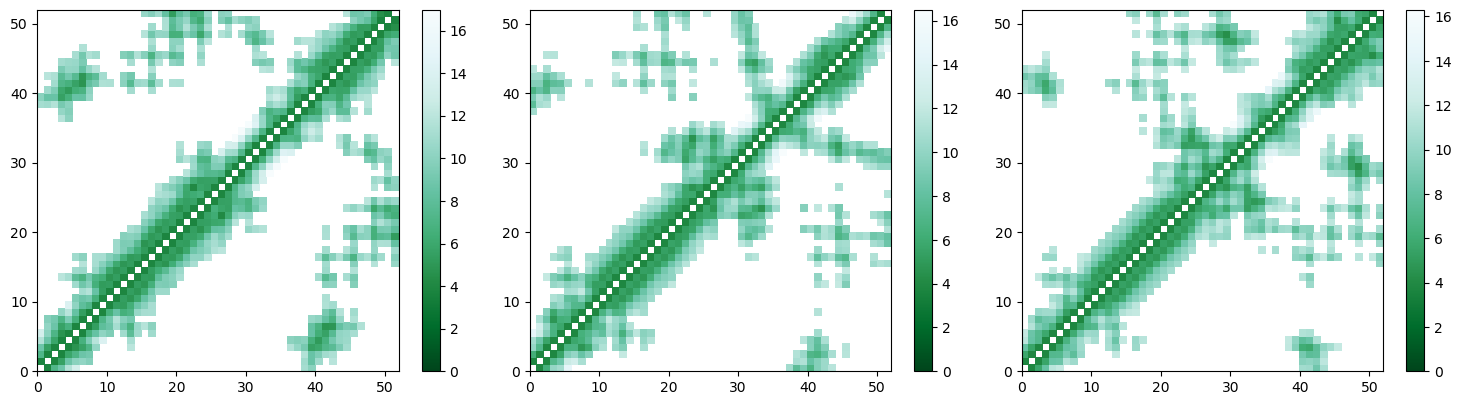

In [224]:
sample = torch.load('CASP13/processed/T0980s2.pth')
fig, axes = plt.subplots(1, 3, figsize=(5*3, 4))

def masked_distance(graph):
    sp = torch_sparse.to_scipy(graph.edge_index, graph.edge_attr[:, 0], graph.num_nodes, graph.num_nodes)
    dense = sp.todense()
    masked = np.ma.masked_equal(dense, value=0)
    return masked

for ax, graph in zip(axes.flat, sample['graphs']):
    print(graph)
    dist = torch_sparse.to_scipy(graph.edge_index, graph.edge_attr[:, 0], graph.num_nodes, graph.num_nodes).todense()
    img = ax.pcolormesh(
        np.where(dist>0, dist, np.nan),
        vmin=0,
        vmax=dist.max(),
        cmap="BuGn_r",
    )
    cbar = fig.colorbar(img, ax=ax)
    ax.set_aspect('equal')
fig.tight_layout()
display(fig)
plt.close(fig)